## Individual Bagging on Decision Tree: CNN featureset

### Importing libraries

In [1]:
import cv2
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout
from keras import optimizers
from tensorflow.keras import datasets, layers, models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Data path and labels

In [2]:

# set image path and categories
data_path = "D:/Individual_Trees_photos/exatctcrop"
categories = os.listdir(data_path)

# initialize lists for features and labels
features_cnn = []
features_glcm = []
labels = []

# load images and extract features
for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (250, 250))
        img_cnn = img_to_array(img)
        img_glcm = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features_cnn.append(img_cnn)
        features_glcm.append(img_glcm)
        labels.append(category)



In [3]:
# convert features and labels to numpy arrays
features_cnn = np.array(features_cnn)
features_glcm = np.array(features_glcm)
labels = np.array(labels)




### CNN model for feature extraction

In [4]:
# create CNN model for feature extraction
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(512, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())


# extract CNN features for all images
features_cnn = model_cnn.predict(features_cnn)
# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



17/17 [==============================] - 3s 165ms/step


In [5]:
print(features_cnn[:10, :])


[[ 0.         0.         0.        ...  0.         3.1937351  6.6234026]
 [ 0.         0.         0.        ...  0.         3.2299535  5.8819118]
 [ 0.         0.         0.        ...  0.         2.2095323  5.013722 ]
 ...
 [ 0.         0.         0.        ...  0.         5.0626955 10.800412 ]
 [ 0.         0.         0.        ...  0.         5.315352   9.628151 ]
 [ 0.         0.         0.        ...  0.         4.2015676  7.8630495]]


In [6]:

# from sklearn.preprocessing import StandardScaler
# # Scale the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(features_cnn)

### Train-test split

In [7]:
# split features and labels into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features_cnn, labels, test_size=0.2, random_state=42)



### Decision tree model

In [8]:
# Define base classifier

dt_clf = DecisionTreeClassifier(random_state=42)


### Bagging


In [12]:
bagging_clf = BaggingClassifier(dt_clf, n_estimators=100, max_samples=0.5, max_features=0.8)
bagging_clf.fit(x_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.8, max_samples=0.5, n_estimators=100)

In [13]:
# bagging_classifier = BaggingClassifier(bagging_models, n_estimators=5)

In [14]:
bagging_pred = bagging_clf.predict(x_test)
bagging_accuracy = accuracy_score(y_test, bagging_pred)


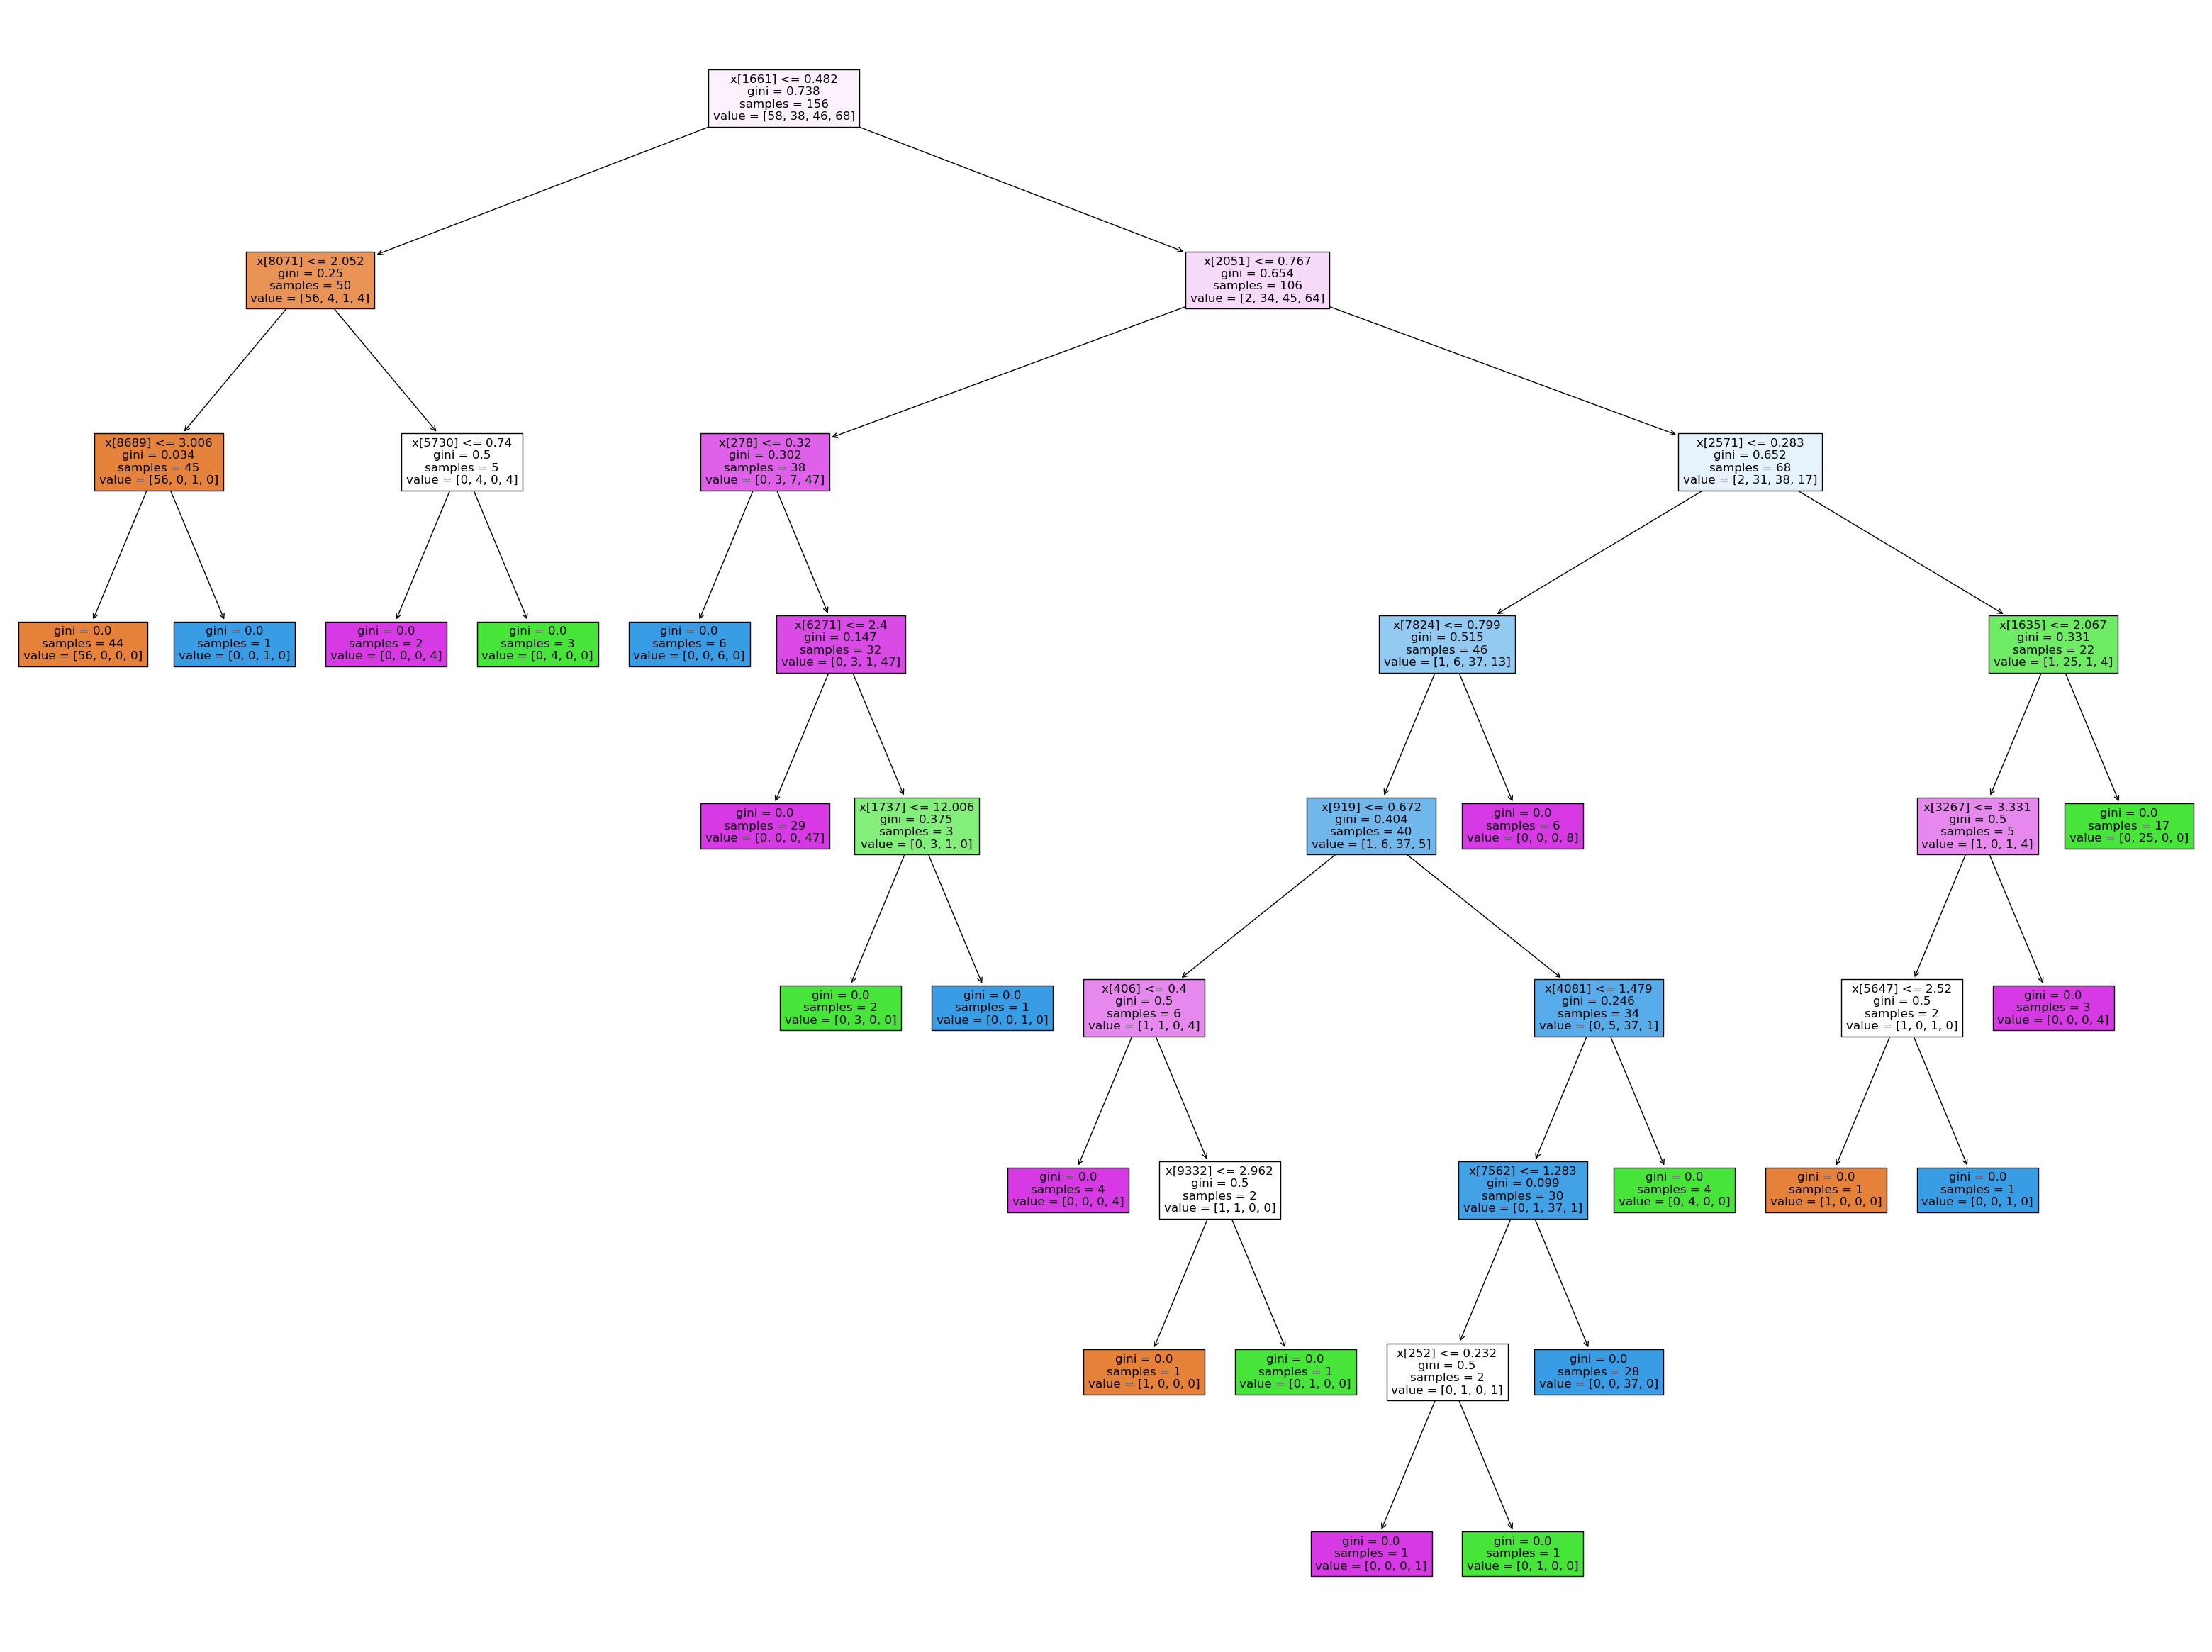

In [15]:
from sklearn.tree import plot_tree

# Plot the first decision tree in the ensemble
plt.figure(figsize=(40, 30))
plot_tree(bagging_clf.estimators_[0], filled=True)
plt.show()


### Training accuracy

In [16]:
# Train accuracy
print('Bagging Classifier Training accuracy:', bagging_clf.score(x_train, y_train))

Bagging Classifier Training accuracy: 0.997624703087886


### Testing accuracy

In [17]:
# Print bagging accuracy
print('Bagging Classifier accuracy:', bagging_accuracy)


Bagging Classifier accuracy: 0.8584905660377359


In [18]:
# evaluate performance of Random Forest model
accuracy = accuracy_score(y_test, bagging_pred)
precision = precision_score(y_test, bagging_pred, average='weighted')
recall = recall_score(y_test, bagging_pred, average='weighted')
f1 = f1_score(y_test, bagging_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.8584905660377359
Precision: 0.8614630022276497
Recall: 0.8584905660377359
F1-score: 0.8591506980840184


### Classification report

In [19]:
# Evaluate the predictions
print(classification_report(y_test, bagging_pred))

                     precision    recall  f1-score   support

     European beech       0.97      0.95      0.96        38
European silver fir       0.84      0.80      0.82        20
      Norway spruce       0.80      0.76      0.78        21
        Sessile oak       0.77      0.85      0.81        27

           accuracy                           0.86       106
          macro avg       0.85      0.84      0.84       106
       weighted avg       0.86      0.86      0.86       106



### Confusion matrix

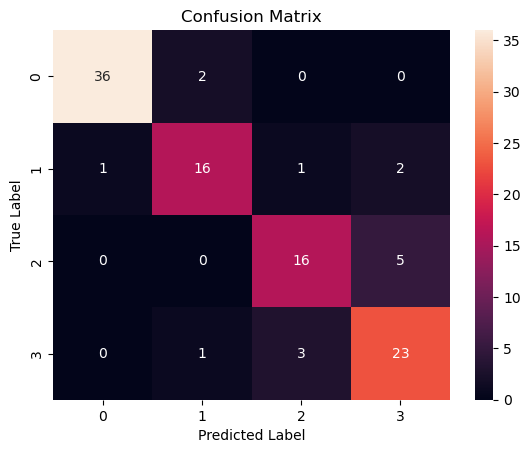

In [20]:
matrix= confusion_matrix(y_test, bagging_pred)

ax=sns.heatmap(matrix,annot = True, fmt = "d")


# Set title and axis labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()